In [10]:
using NPZ: npzread

N = 10^4
X_train = convert(Matrix{Float32}, npzread("X_train.npy"))[1:N, :]
Y_train = convert(Vector{Int8}, npzread("Y_train.npy"))[1:N]
#Y_train = convert(Vector{Float32}, npzread("Y_train.npy"))[1:N]
X_test = convert(Matrix{Float32}, npzread("X_test.npy"))[1:N, :]
#Y_test = convert(Vector{Float32}, npzread("Y_test.npy"))[1:N];
Y_test = convert(Vector{Int8}, npzread("Y_test.npy"))[1:N];

In [12]:
X = transpose(X_train)
Y = onehotbatch(Y_train, 0:1)
tX = transpose(X_test)
tY = onehotbatch(Y_test, 0:1)

2×10000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  1  1  0  1  0  0  1  0  0  1  …  0  1  0  0  1  1  0  1  1  1  0  1
 1  1  1  0  0  1  0  1  1  0  1  1  0     1  0  1  1  0  0  1  0  0  0  1  0

## Flux

In [93]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
import PyPlot; const plt = PyPlot
using PyCall
using LaTeXStrings

In [19]:
function study(opt, lrs, afs, neurons)

    epochs = 50
    dataset = repeated((X, Y), epochs)
    N = length(dataset)
    results = []
    
    for o in opt, lr in lrs, activation in afs, neuron in neurons
        #@show o, lr, activation, neuron
        m = Chain(
          Dense(40*40, neuron, activation),
          Dense(neuron, 2),
          softmax)
        @show m
        
        loss(x, y) = crossentropy(m(x), y)
        rloss(x, y) = loss(x, y).data
        accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))
       
        optimizer = try o(η = lr) 
            catch 
            o(lr)
        end
        #optimizer = Descent()

        acc = zeros(epochs)
        tacc = similar(acc)
        epoch = 1
        evalcb = () -> begin
            acc[epoch] = accuracy(X, Y)
            tacc[epoch] = accuracy(tX, tY)
            epoch += 1
        end

        try
            @time Flux.train!(loss, Flux.params(m), dataset, optimizer, cb = evalcb)
        catch
            println("Failed")
        end
        push!(results, (o, lr, activation, neuron) => (acc, tacc))
    end
    results
end

study (generic function with 1 method)

In [101]:
results = study([Nesterov], [0.001, 0.01, 0.1], [relu, sigmoid, leakyrelu], [1, 5, 10, 50, 100])

m = Chain(Dense(1600, 1, relu), Dense(1, 2), softmax)
  6.801899 seconds (9.88 M allocations: 3.313 GiB, 8.73% gc time)
m = Chain(Dense(1600, 5, relu), Dense(5, 2), softmax)
  6.920745 seconds (9.88 M allocations: 3.387 GiB, 6.44% gc time)
m = Chain(Dense(1600, 10, relu), Dense(10, 2), softmax)
  7.046583 seconds (9.88 M allocations: 3.480 GiB, 6.06% gc time)
m = Chain(Dense(1600, 50, relu), Dense(50, 2), softmax)
  8.634641 seconds (9.88 M allocations: 4.222 GiB, 5.84% gc time)
m = Chain(Dense(1600, 100, relu), Dense(100, 2), softmax)
 12.986393 seconds (9.88 M allocations: 5.150 GiB, 4.98% gc time)
m = Chain(Dense(1600, 1, σ), Dense(1, 2), softmax)
  5.999495 seconds (9.88 M allocations: 3.313 GiB, 6.57% gc time)
m = Chain(Dense(1600, 5, σ), Dense(5, 2), softmax)
  6.604497 seconds (9.88 M allocations: 3.387 GiB, 6.15% gc time)
m = Chain(Dense(1600, 10, σ), Dense(10, 2), softmax)
  6.970387 seconds (9.88 M allocations: 3.480 GiB, 5.55% gc time)
m = Chain(Dense(1600, 50, σ), Dense(50,

45-element Array{Any,1}:
       (Nesterov, 0.001, NNlib.relu, 1) => ([0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326  …  0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5326, 0.5043], [0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385  …  0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.5385, 0.4934])                                                                                                                                                                                                                                                       
       (Nesterov, 0.001, NNlib.relu, 5) => ([0.4324, 0.4247, 0.4095, 0.6095, 0.651, 0.6673, 0.6178, 0.6626, 0.6535, 0.6645  …  0.8786, 0.88, 0.8812, 0.8823, 0.8833, 0.8838, 0.8843, 0.8849, 0.8856, 0.8862], [0.4308, 0.416, 0.4041, 0.6014, 0.6504, 0.6592, 0.6147, 0.6566, 0.6478, 0.6574  …  0.8744, 0.8749, 0.8752, 0.8764, 0.8771, 0.8777, 0.8786, 0.8801, 0

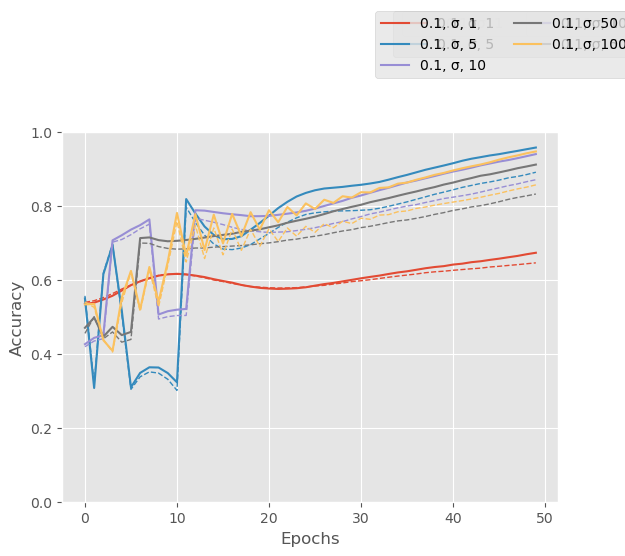

In [131]:
plt.clf()
@pywith plt.matplotlib.pyplot.style.context("ggplot") begin
fig, ax = plt.subplots()
for ((opt, lr, a, n), (acc, tacc)) in results
        #if (a != relu && a != leakyrelu) || lr != 0.001 continue end
        if a != sigmoid || lr != 0.1 continue end
    lines = ax.plot(acc, label="$lr, $a, $n")
    ax.plot(tacc, "--", lw=1, c=lines[1].get_color())
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    #ax.set_yscale("log")
    fig.legend(loc=1, ncol=2, frameon=true,
            bbox_to_anchor=(0.0, 1.1, 1, 0.05))
end
end

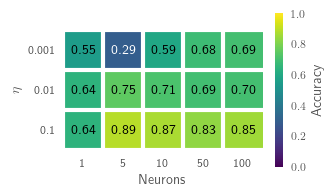

In [123]:
lr = [0.001, 0.01, 0.1]
n = [1, 5, 10, 50, 100]
grid = zeros(3, 5)
for (hyper, (train, test)) in results
    if hyper[3] != sigmoid continue end
    i = findfirst(x -> x == hyper[2], lr)
    j = findfirst(x -> x == hyper[4], n)
    grid[i, j] = test[end]
end
@pywith plt.matplotlib.pyplot.style.context("rapport") begin
    fig, ax = plt.subplots()
    cax = ax.imshow(grid, vmin=0, vmax=1)
    ax.set_xticks(0:size(grid, 2) - 1)
    ax.set_yticks(0:size(grid, 1))
    ax.set_xticklabels(n)
    ax.set_yticklabels(lr) 
    ax.set_xlabel("Neurons")
    ax.set_ylabel(L"$\eta$")
   # We want to show all ticks...
    xticks = (0:size(grid, 2) - 1) .- 0.5
    yticks = (0:size(grid, 1)) .- 0.5
    ax.set_xticks(xticks, minor=true)
    ax.set_yticks(yticks, minor=true)
    # Turn spines off and create white grid.
    for (edge, spine) in ax.spines
        spine.set_visible(false)
    end
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.grid(which="major", false)
    ax.tick_params(which="minor", bottom=false, left=false)
    # ... and label them with the respective list entries
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("Accuracy", va="top") 
    cbar.outline.set_linewidth(0)
    
    for i in 1:size(grid, 1), j in 1:size(grid, 2)
        col = if grid[i, j] < 0.5
                "w"
            else 
            "k"
        end
        acc = string(grid[i, j])
        acc = if length(acc) < 4 acc else acc[1:4] end
        if grid[i, j] < 0.05
            acc = "NaN"
        end
        if grid[i, j] < 0 || grid[i, j] > 1
            acc = "NaN"
        end
        cax.axes.text(j-1, i-1, acc, horizontalalignment="center",
        verticalalignment="center", color=col)
    end
    fig.savefig("../latex/figures/sigmoidgrid.png", dpi=300, bbox_inches="tight", transparent=true)
end

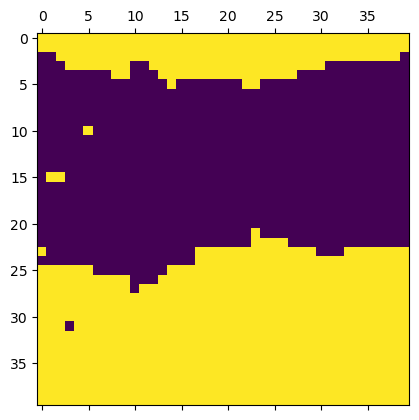

PyObject <matplotlib.image.AxesImage object at 0x7fab9a10e610>

In [34]:
plt.matshow(reshape(ordered[:, 1174], 40, 40))

In [11]:
using Random
using PyCall
include("../src/classification.jl")
using Main.Classification: traintestsplit
Random.seed!(4)

sklsets = pyimport("sklearn.datasets")
observables, target = sklsets.make_classification(n_samples=2000, n_features=25, n_informative=24,
n_redundant=1, n_repeated=0, n_classes=2, random_state=42, flip_y=0.05, class_sep=1.0)
(Xtrain, Ytrain), (Xtest, Ytest) = traintestsplit(observables, target, 0.8, 2000)
Xtrain, Ytrain = (Xtrain, Ytrain) .|> collect ∘ transpose;
Xtest, Ytest = (Xtest , Ytest ) .|> collect ∘ transpose;

## Custom Neural Net

In [1]:
include("../src/classification.jl")
using Main.Classification

In [21]:
using NPZ: npzread

N = 10000
X_train = convert(Matrix{Float32}, npzread("X_train.npy"))[1:N, :]
Y_train = convert(Vector{Int8}, npzread("Y_train.npy"))[1:N]
#Y_train = convert(Vector{Float32}, npzread("Y_train.npy"))[1:N]
X_test = convert(Matrix{Float32}, npzread("X_test.npy"))[1:N, :]
#Y_test = convert(Vector{Float32}, npzread("Y_test.npy"))[1:N];
Y_test = convert(Vector{Int8}, npzread("Y_test.npy"))[1:N];

In [22]:
X = transpose(X_train) |> collect
labels = transpose(Y_train) |> collect
Y = onehot(Y_train) 
tX = transpose(X_test) |> collect
tY = Y_test;

In [23]:
function study(opt, lrs, afs, neurons)

    epochs = 50
    #dataset = repeated((X, Y), epochs)
    results = []
    
    for o in opt, lr in lrs, activation in afs, neuron in neurons
        @show o, lr, activation, neuron
        
        # Set up optimizer
        optim = optwrapper(o)(η = lr, epochs=epochs)
        addvalidationset!(optim, tX, tY)
        
        net = NeuralNet()
        addSigmoidLayer!(net, neuron)
        addSigmoidLayer!(net, 2)
        
        @time fit!(net, optim, copy(X), copy(Y), copy(labels))
        push!(results, (o, lr, activation, neuron) => (optim.loss, optim.validationloss))
    end
    results
end

optwrapper(::Type{GradientDescent}) = (;η, epochs) ->GradientDescent(GDContext(learningrate=η, maxiterations=epochs))
optwrapper(::Type{StochasticGradientDescent}) = (;η, epochs)->StochasticGradientDescent(SGDContext(learningrate=η, maxiterations=epochs))

optwrapper (generic function with 2 methods)

In [27]:
results = study([GradientDescent, StochasticGradientDescent], [0.01], [nothing], [5, 50])

(o, lr, activation, neuron) = (GradientDescent, 0.01, nothing, 5)
 43.389878 seconds (32.51 M allocations: 49.634 GiB, 10.06% gc time)
(o, lr, activation, neuron) = (GradientDescent, 0.01, nothing, 50)
200.758126 seconds (32.51 M allocations: 453.568 GiB, 15.53% gc time)
(o, lr, activation, neuron) = (StochasticGradientDescent, 0.01, nothing, 5)
 34.616452 seconds (32.37 M allocations: 49.293 GiB, 12.30% gc time)
(o, lr, activation, neuron) = (StochasticGradientDescent, 0.01, nothing, 50)
221.220876 seconds (32.37 M allocations: 450.507 GiB, 15.28% gc time)


4-element Array{Any,1}:
            (GradientDescent, 0.01, nothing, 5) => (Float32[0.5539, 0.5545, 0.5546, 0.5548, 0.5556, 0.5559, 0.5568, 0.5574, 0.5578, 0.5583  …  0.5659, 0.5662, 0.5662, 0.5664, 0.5664, 0.5665, 0.5666, 0.5666, 0.5666, 0.5666], Float32[0.5544, 0.5552, 0.5559, 0.5565, 0.5567, 0.5571, 0.5574, 0.5576, 0.558, 0.5586  …  0.5657, 0.5658, 0.5659, 0.5659, 0.5659, 0.5661, 0.5662, 0.5664, 0.5665, 0.5665])
           (GradientDescent, 0.01, nothing, 50) => (Float32[0.4503, 0.4512, 0.4525, 0.4534, 0.454, 0.4552, 0.5919, 0.5935, 0.5946, 0.5954  …  0.6195, 0.6197, 0.6206, 0.621, 0.6213, 0.6217, 0.6221, 0.6221, 0.6222, 0.6226], Float32[0.4493, 0.4506, 0.4514, 0.4527, 0.4547, 0.4558, 0.5937, 0.5954, 0.5958, 0.5978  …  0.6231, 0.6233, 0.6242, 0.6247, 0.6247, 0.625, 0.6255, 0.6256, 0.626, 0.6265])   
  (StochasticGradientDescent, 0.01, nothing, 5) => (Float32[0.3615, 0.363, 0.3646, 0.3661, 0.3752, 0.378, 0.3788, 0.38, 0.3812, 0.3909  …  0.6727, 0.6735, 0.6736, 0.674, 0.6744, 0.675, 0

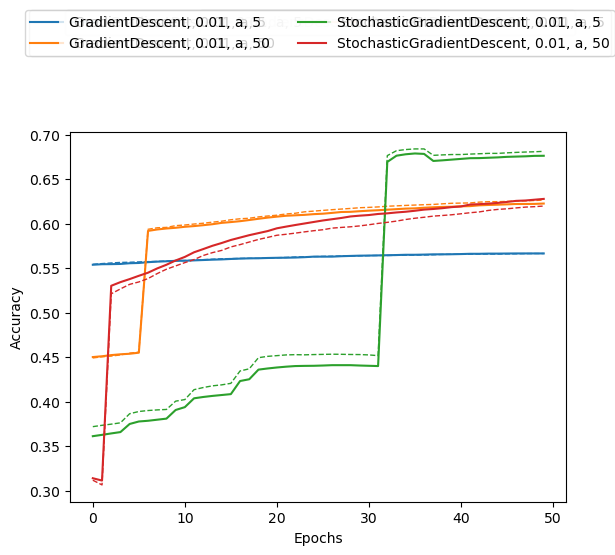

In [28]:
import PyPlot; const plt = PyPlot
plt.clf()
fig, ax = plt.subplots()
for ((opt, lr, a, n), (acc, tacc)) in results
    lines = ax.plot(acc, label="$opt, $lr, a, $n")
    ax.plot(tacc, "--", lw=1, c=lines[1].get_color())
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    #ax.set_yscale("log")
    fig.legend(loc=9, ncol=2, frameon=true,
            bbox_to_anchor=(0.0, 1.1, 1, 0.05))
end

## Flux Regression

In [142]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Flux: @epochs
using Base.Iterators: repeated
import PyPlot; const plt = PyPlot
using PyCall

In [149]:
using Distributions
using Random
Random.seed!(59)
regX = rand(100)
regY = 100 * regX + rand(Normal(0, 10), 100)
regData = []
for (x, y) in zip(regX, regY)
    push!(regData, ([x], [y]))
end

In [74]:
function linear(in, out)
    W = param(randn(out, in))
    b = param(randn(out))
    x -> W * x .+ b
end

modelReg = Chain(Dense(1, 1), identity)
loss(x, y) = Flux.mse(modelReg(x), y)
opt = Descent(0.1)
data = regData #repeated(regData, 100)
Flux.train!(loss, Flux.params(modelReg), data, opt)

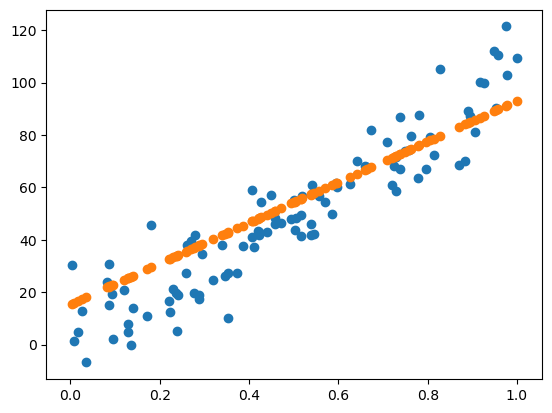

PyObject <matplotlib.collections.PathCollection object at 0x7efc35f577d0>

In [76]:
fig, ax = plt.subplots()
ax.scatter(regX, regY)
yhat = [x.data for x in modelReg(regX')]
ax.scatter(regX, yhat)

In [85]:
using NPZ: npzread
Xtrain = npzread("1D_xtrain.npy")#[1:1000, :]
Ytrain = npzread("1D_ytrain.npy")#[1:1000]
Xtest = npzread("1D_xtest.npy")#[1:1000, :]
Ytest = npzread("1D_ytest.npy")#[1:1000];

In [86]:
data = [(Xtrain[i, :], Ytrain[i]) for i in 1:size(Xtrain, 1)];

In [94]:
X = Xtrain |>transpose
Y = Ytrain 
tX = Xtest |> transpose
tY = Ytest;

In [164]:
function regIsing()
    m = Chain(Dense(40*40, 1, relu), identity)
    loss(x, y) = Flux.mse(m(x), y)

    opt = Descent(0.0001)
    @epochs 10 Flux.train!(loss, Flux.params(m), data, opt)#, cb=evalcb)
    m
end

regIsing (generic function with 1 method)

In [165]:
m = regIsing()

┌ Info: Epoch 1
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/erdos/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


Chain(Dense(1600, 1, relu), identity)

In [26]:
function untrack(X)
    x = zeros(size(X))
    for i in eachindex(X)
        x[i] = X[i].data
    end
    x
end

untrack (generic function with 1 method)

In [140]:
function R2(ypred, y)
    SStot = sum((y .- mean(y)).^2)
    SSres = sum((y .- ypred).^2)
    return 1 - SSres/SStot
end

R2 (generic function with 1 method)

In [162]:
w = reshape(untrack(m[1].W), 40, 40);

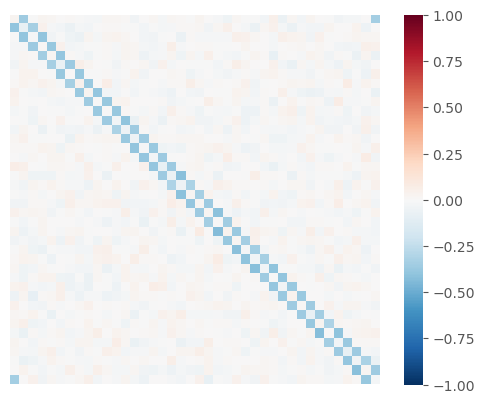

In [166]:
@pywith plt.matplotlib.pyplot.style.context("ggplot") begin
    fig, ax = plt.subplots()
    im = ax.matshow(w, vmin=-1, vmax=1, cmap="RdBu_r")
    cbar= fig.colorbar(im)
    cbar.outline.set_linewidth(0)
    ax.axis("off")
    #fig.savefig("../latex/figures/nnising.png", dpi=300, bbox_inches="tight", transparent=true)
end

In [139]:
@show mean(untrack(m(tX)) .- tY)
@show R2(untrack(m(tX)), tY)

mean(untrack(m(tX)) .- tY) = 9.403087509175141e-7
ypred |> size = (1, 3000)
y |> size = (1, 3000)
y .- ypred |> size = (1, 3000)
SStot = 122465.19466666663
SSres = 1.2106940791100198e-6
SStot / SSres = 1.0115288145845291e11
R2(untrack(m(tX)), tY) = 0.999999999990114


0.999999999990114

## Custom NN Regression

In [104]:
include("../src/classification.jl")
using Main.Classification

In [105]:
using NPZ: npzread
Xtrain = npzread("1D_xtrain.npy")#[1:1000, :]
Ytrain = npzread("1D_ytrain.npy")#[1:1000]
Xtest = npzread("1D_xtest.npy")#[1:1000, :]
Ytest = npzread("1D_ytest.npy")#[1:1000];

In [113]:
X = Xtrain |> transpose |> collect
Y = Ytrain |> transpose |> collect
tX = Xtest |> transpose |> collect
tY = Ytest |> transpose |> collect;

In [125]:
net = NeuralNet([(1, :id)])
optim = StochasticGradientDescent(SGDContext(learningrate=0.0001))
@time fit!(net, optim, copy(X), copy(Y), copy(Y))

InexactError: InexactError: Int64(-13.25704)

## Response Functions

In [3]:
#include("../src/classification.jl")
#using Main.Classification
import PyPlot; const plt = PyPlot
using PyCall

In [1]:

"""
    σ(x)

Sigmoid activation function
"""
σ(x::Real) = one(x)/(one(x) + exp(-x))
∇σ(x::Real) = σ(x)*(one(x) - σ(x))

"""
    relu(x)

Rectified Linear Unit activation function
"""
relu(x::Real) = max(zero(x), x)
∇relu(x::Real) = if x ≥ zero(x) one(x) else zero(x) end

"""
    leakyrelu(x)

Leaky Rectified Linear Unit activation function
"""
leakyrelu(x::Real, a = oftype(x, 0.01)) = max(a*x, x)
∇leakyrelu(x::Real, a = oftype(x, 0.01)) = if x ≥ zero(x) one(x) else a end


∇leakyrelu (generic function with 2 methods)

In [26]:
fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches

@pywith plt.matplotlib.pyplot.style.context("rapport") begin
fig, axes = plt.subplots(ncols=3, sharex=false, sharey=true,
figsize=(2.5*fig_width, fig_height))
x = collect(-5:0.01:5)
line = axes[1].plot(x, σ.(x))
axes[1].plot(x, ∇σ.(x),"--", c=line[1].get_color())
x = collect(-1:0.01:1)
line = axes[2].plot(x, relu.(x))
axes[2].plot(x, ∇relu.(x),"--", c=line[1].get_color())
line = axes[3].plot(x, leakyrelu.(x))
axes[3].plot(x, ∇leakyrelu.(x),"--", c=line[1].get_color())
axes[1].set_ylim([-0.1, 1.1])
axes[1].set_title("Sigmoid")
axes[2].set_title("ReLU")
axes[3].set_title("Leaky ReLU")
fig.savefig("../latex/figures/activations.png", dpi=300, bbox_inches="tight")
end

PyPlot.Figure(PyObject <Figure size 806.351x199.341 with 3 Axes>)